MACHINE LEARNING PROJECT: Pneumonia Detection pt1 - Matteo Framba 0000934140- 28-06-2021

# INTRODUCTION

In this project we will build a classification model of an X-ray image of the lungs to predict the presence of pneumonia. First we import the necessary modules.

In [1]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt



For this project will be used the **Tensor Processing Unit** (TPU), an AI accelerator application-specific integrated circuit (ASIC) developed by Google specifically for neural network machine learning.

This accelerator is currently available for Keras and Google Colab. Before running the code, it is therefore necessary to ensure that the hardware accelerator has the correct setting. Once you have opened the file in Colab, follow these steps: **Runtime > Change runtime type > Hardware accelerator > TPU.**



In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() #The TPU initialization code has to be at the beginning of the program.
    #print("Device:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: grpc://10.59.45.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.59.45.234:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of replicas: 8


Let's define the key configuration parameters that will be used in this project, the batch size (we choose 200), the image size and the class names.

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE #This module contains experimental Dataset sources to optimize different parts of input loading.
BATCH_SIZE = 25 * strategy.num_replicas_in_sync # number of samples that will be propagated through the network. Standard way with TPU
IMAGE_SIZE = [180, 180]
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

# Load the data

The data used was collected by Cell in 2017 and already divided into the 3 categories "train", "test", "val". Each category has two folders depending on whether the image has pneumonia or not ("Pneumonia", "Normal").

[see http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5 for more information].

In [4]:
train_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec"
)
train_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec"
)

ds = tf.data.Dataset.zip((train_images, train_paths)) #Creates a Dataset by zipping together the given datasets.

Let us now count the number of total images and in particular the division between healthy and sick patients. 

It will be observed that the data is unbalanced and we should therefore create a weight to balance it later on.

In [113]:
COUNT_NORMAL = len(
    [
        filename
        for filename in train_paths
        if "NORMAL" in filename.numpy().decode("utf-8")
    ]
)
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len(
    [
        filename
        for filename in train_paths
        if "PNEUMONIA" in filename.numpy().decode("utf-8")
    ]
)
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1349
Pneumonia images count in training set: 3883


As we anticipated, there are more images of patients with pneumonia than normal images.

We now want to create a connection between each filename and the corresponding image-description pair. to do this we create the following methods in which we indicate with 1 (=true) if there is pneumonia and 0 (= false) otherwise.

In [5]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, "/")
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size.
    return tf.image.resize(img, IMAGE_SIZE)


def process_path(image, path):
    label = get_label(path)
    # load the raw data from the file as a string
    img = decode_img(image)
    return img, label


ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)


now let's split the data: create our training and validation set

In [6]:
ds = ds.shuffle(10000)
train_ds = ds.take(4200)
val_ds = ds.skip(4200)

we will now show the description of each image-label

In [72]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy()) #true = pneumonia. False= no pneumonia

Image shape:  (180, 180, 3)
Label:  True


Finally, we load the test data and format it as we did before

In [88]:
test_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)
test_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec"
)
test_ds = tf.data.Dataset.zip((test_images, test_paths))

test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

# Visualize the dataset

We speed up the process by buffered prefetching, i.e. taking data from their original memory in a slower memory to a faster local memory before they are actually needed.

Note that we cached large images here because we want to train on TPU

In [74]:

def prepare_for_training(ds, cache=True):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str): #returns true if cache is a string, false if it isn't.
            ds = ds.cache(cache) # Caches the elements in this dataset.
        else:
            ds = ds.cache() #will have no effect until the cache file 
                            #is removed or the filename is changed.
    ds = ds.batch(BATCH_SIZE) #Combines consecutive elements of this dataset into batches.
    ds = ds.prefetch(buffer_size=AUTOTUNE) #lets the dataset fetch batches in 
                                           #the background while the model is training. (FASTENING THE PROCESS)
    return ds

Let's apply the method to the training and validation dataset

In [89]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

We now want to display the images in the batch: we will define the following method. . We will display 25 randomly taken images with their disease positivity or negativity labels.

In [38]:

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255)
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


Let us now display the images

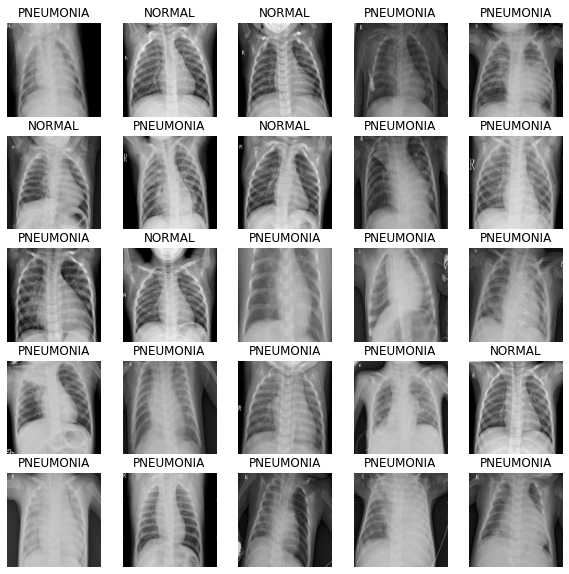

In [39]:
show_batch(image_batch, label_batch) 


# Build the CNN

For the construction of my NN, I decided to define two modules in order to simplify the notation. We will use the first method for five convolutional blocks and the second one for four fully connected layers.

In [90]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


def conv_block(filters, inputs):
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(inputs) #same = stessa dimensione input/output
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.MaxPool2D()(x)

    return outputs


def dense_block(units, dropout_rate, inputs):  #units = a quanti neauroni voglio arrivare
    x = layers.Dense(units, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dropout(dropout_rate)(x)  #prevengo overfitting togliendo nodi = togliendo parametri

    return outputs

We define a method that creates the Neural Network as described above: we will use ReLu as activation functions except for the last layer: being a binary classification problem we will use a Sigmoid.

As an optimiser we will use Adam, and as a loss we will use cross entropy.

In [101]:
def build_model():
    inputs = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = preprocessing.Rescaling(1.0 / 255)(inputs)
    
    # first conv block
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x) #padding= aggiungo 0 sulla cornice per non perdere informazioni
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)  #relu = pongo a 0 i valori negativi
    x = layers.MaxPool2D()(x) #prendo il massimo di una sottomatrice 

    #second conv block
    x = conv_block(32, x)

    #third conv block
    x = conv_block(64, x)

    # fourth conv block
    x = conv_block(128, x)
    x = layers.Dropout(0.2)(x)   #prevengo overfitting togliendo nodi = togliendo parametri (impongo il peso valga 0)

    #fifth conv block
    x = conv_block(256, x)
    x = layers.Dropout(0.2)(x) #prevengo overfitting togliendo nodi = togliendo parametri (impongo il peso valga 0)

    # FC layer
    x = layers.Flatten()(x)  # da matrice a vettore (riduco la dimensione dell'input)
    x = dense_block(512, 0.7, x)
    x = dense_block(128, 0.5, x)
    x = dense_block(64, 0.3, x)

    # Output layer
    outputs = layers.Dense(1, activation="sigmoid")(x) #classificazione binaria = sigmoide

    # Creating model
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model
#model.summary()

# Data imbalance

We are going to define a weight to correct for the imbalance in the data. We had observed earlier that there were many more pneumonia cases than normal.

In [78]:
initial_bias = np.log([COUNT_PNEUMONIA / COUNT_NORMAL])
print("Initial bias: {:.5f}".format(initial_bias[0]))

TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA    #total images
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0       # weight for normal
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0    # weight for pneumonia

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Initial bias: 1.05724
Weight for class 0: 1.94
Weight for class 1: 0.67


We observe that, predictably,  the weight for the class with pneumonia is about one third of the other: we will weigh each image as the CNN works best if the data is balanced. 

# Training


## Improving performance

Before training, we define two callbacks: the **modelCheckPoint** and **EarlyStopping**.

The first method is used to save a copy of the best performing model when an epoch in which the metrics have improved has ended.

The second method is used to avoid overfitting and stops training when the generalisation gap (i.e. the difference between training and validation error) starts to increase.

Let's then tune our **learning rate**. We know that if it is too high, the model will diverge, and if it is too low, the process is very slow. We show the third method as a solution

In [91]:
#Checkpoint    (salvo il modello, con i pesi, alla fine di ogni epoch)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

#early stopping  (se acc-train molto distante da acc-val dopo 10 epochs)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

# learning rate
initial_learning_rate = 0.015    #parto da questo e poi cambia, usiamo le medie mobili esponenziali (hanno + importanza le epoche vicine)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

# Quality of the model

Generally accuracy is a way to test the goodness of a model, however in our case, having unbalanced data risks formalising biased results.

For this reason more value will be given to accuracy and recall. Let us quickly recall their definitions.

Precision: TP / (TP + FP). It shows what fraction of labeled positives are actually correct.

Recall: TP / (TP + FN).
It shows what
fraction of actual positives are correct.

Since there are only two possible labels for the image, we will be using the binary crossentropy loss. 

The training will be very fast because we are using the TPU accelerator.



In [92]:
with strategy.scope():
    model = build_model()

    METRICS = [
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ]
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="binary_crossentropy",
        metrics=METRICS,
    )

history = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
21/21 [==============================] - 27s 408ms/step - loss: 0.6943 - binary_accuracy: 0.6143 - precision: 0.8457 - recall: 0.5874 - val_loss: 9.7936 - val_binary_accuracy: 0.2539 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
21/21 [==============================] - 3s 123ms/step - loss: 0.3978 - binary_accuracy: 0.8057 - precision: 0.9546 - recall: 0.7751 - val_loss: 1.4923 - val_binary_accuracy: 0.5039 - val_precision: 0.9358 - val_recall: 0.3597
Epoch 3/100
21/21 [==============================] - 3s 120ms/step - loss: 0.2730 - binary_accuracy: 0.8881 - precision: 0.9668 - recall: 0.8794 - val_loss: 0.6016 - val_binary_accuracy: 0.7461 - val_precision: 0.9757 - val_recall: 0.6766
Epoch 4/100
21/21 [==============================] - 2s 120ms/step - loss: 0.2101 - binary_accuracy: 0.9131 - precision: 0.9738 - recall: 0.9073 - val_loss: 1.5580 - val_binary_accuracy: 0.7500 - val_precision: 0.7490 - val_recall: 1.0000
Epoch 5/100
21/21 [================

## Visualizing model performance


Let us now display the performance for the training and validation set

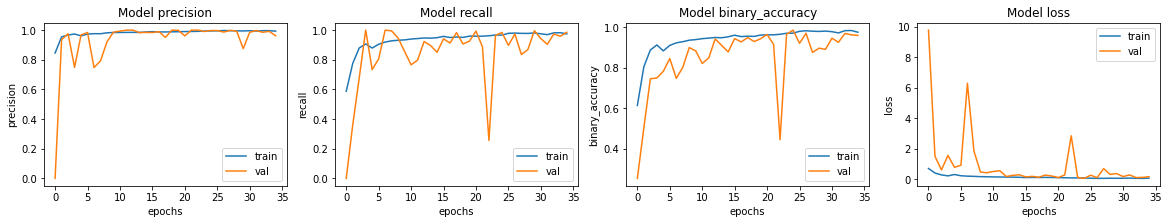

In [93]:

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "binary_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

# Prediction of results

In [94]:
model.evaluate(test_ds, return_dict=True)

4/4 [==============================] - 3s 677ms/step - loss: 1.2030 - binary_accuracy: 0.7853 - precision: 0.7481 - recall: 0.9897


{'binary_accuracy': 0.7852564454078674,
 'loss': 1.203019142150879,
 'precision': 0.7480619549751282,
 'recall': 0.9897436499595642}

We note that we may be overfitting because the accuracy of the test data is less than that of the validation data.

The recall is greater than the precision, so we are correctly identifying the images but also creating false positives.

We conclude the report by taking the first image from the test dataset and showing the prediction percentage

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  This is separate from the ipykernel package so we can avoid doing imports until


This image is 9.24 percent NORMAL
This image is 90.76 percent PNEUMONIA


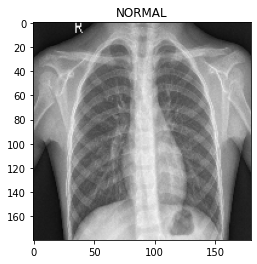

In [96]:
for image, label in test_ds.take(1):
    plt.imshow(image[0] / 255.0)
    plt.title(CLASS_NAMES[label[0].numpy()])

prediction = model.predict(test_ds.take(1))[0]
scores = [1 - prediction, prediction]

for score, name in zip(scores, CLASS_NAMES):
    print("This image is %.2f percent %s" % ((100 * score), name))